# Training a cNN to detect roadsigns
In order to process roadsigns in the autonomous car of the Freie Universität, we want to train a convolutional (deep) neural network.

This network is supposed to distinguish between different classes of signs (stop, attention, train crossing etc) and the final model will then be integrated to the autonomos ROS structure.

This notebook shall download the dataset, read it in and then train the classifier. Afterwards, a validation of the training procedure will be done.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import urllib2, cStringIO, zipfile
import csv
import os
import random

## Set global parameters such as image size or channels

**Options include:**
* Size of the images
* Which color channels are used (RGB or YUV)
* How many new images are artificially added

In [2]:
img_size = (32, 32)

## Download the training dataset

In [5]:
url = 'http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip'

if not os.path.exists('GTSRB/Final_Training/Images'):
    try:
        remotezip = urllib2.urlopen(url)
        zipinmemory = cStringIO.StringIO(remotezip.read())
        zip = zipfile.ZipFile(zipinmemory)
        zip.extractall('.')
    except urllib2.HTTPError:
        pass

## Download the test dataset

In [24]:
url = 'http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip'

if not os.path.exists('GTSRB/Final_Test/Images'):
    try:
        remotezip = urllib2.urlopen(url)
        zipinmemory = cStringIO.StringIO(remotezip.read())
        zip = zipfile.ZipFile(zipinmemory)
        zip.extractall('.')
    except urllib2.HTTPError:
        pass

## Read the data in and scale it to a fixed resolution

In [53]:
def getSingleImage(path):
    img = Image.open(path) # the 1th column is the filename
    img_resized = img.resize((img_size[0], img_size[1]), Image.LINEAR)
    img_resized = img_resized.convert('YCbCr')
    Y_channel = img_resized.split()[0]
    del img, img_resized
    return np.array(Y_channel.getdata(), dtype=np.float32).reshape(img_size[0], img_size[1], 1)

def read_training_set(rootpath, train_test_split):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''

    training_images = [] # images
    training_labels = [] # corresponding labels
    
    test_images = [] # images
    test_labels = [] # corresponding labels

    # loop over all 43 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        gtReader.next() # skip header

        # loop over all images in current annotations file
        for row in gtReader:
            np_img = getSingleImage(prefix + row[0]) # the 1th column is the filename
            
            if random.random() <= train_test_split:
                test_images.append(np_img)
                test_labels.append(row[7])
            else:
                training_images.append(np_img)
                training_labels.append(row[7])
        gtFile.close()
        print "Loaded images from class " + str(c)
    return (training_images, training_labels, test_images, test_labels)

def read_test_set(rootpath):

    images = [] # images
    gtFile = open(rootpath + '/GT-final_test.test.csv') # annotations file
    gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
    gtReader.next() # skip header

    # loop over all images in current annotations file
    for row in gtReader:
        print "Filename: " + rootpath + '/' + row[0]
        np_img = getSingleImage(rootpath + '/' + row[0]) # the 1th column is the filename
        images.append(np_img)
    gtFile.close()

    return (images, labels)

In [60]:
trainImg, trainLabels, testImg, testLabels = read_training_set('GTSRB/Final_Training/Images', 0.1)

Loaded images from class 0
Loaded images from class 1
Loaded images from class 2
Loaded images from class 3
Loaded images from class 4
Loaded images from class 5
Loaded images from class 6
Loaded images from class 7
Loaded images from class 8
Loaded images from class 9
Loaded images from class 10
Loaded images from class 11
Loaded images from class 12
Loaded images from class 13
Loaded images from class 14
Loaded images from class 15
Loaded images from class 16
Loaded images from class 17
Loaded images from class 18
Loaded images from class 19
Loaded images from class 20
Loaded images from class 21
Loaded images from class 22
Loaded images from class 23
Loaded images from class 24
Loaded images from class 25
Loaded images from class 26
Loaded images from class 27
Loaded images from class 28
Loaded images from class 29
Loaded images from class 30
Loaded images from class 31
Loaded images from class 32
Loaded images from class 33
Loaded images from class 34
Loaded images from class 35
Lo

In [34]:
testImg = read_test_set('GTSRB/Final_Test/Images')

Filename: GTSRB/Final_Test/Images/00000.ppm


IndexError: list index out of range

In [61]:
print "Number of training images: " + str(len(trainImg))
print "Number of training labels: " + str(len(trainLabels))
print "Number of testing images: " + str(len(testImg))
print "Number of testing labels: " + str(len(testLabels))
print "Train Test Ratio: " + str(len(trainImg) / (len(testImg)*100.))

Number of training images: 35280
Number of training labels: 35280
Number of testing images: 3929
Number of testing labels: 3929
Train Test Ratio: 0.0897938406719


## Permute the training data randomly and make it a big matrix

In [62]:
permutation = np.random.permutation(len(trainImg))
train_set = np.array([trainImg[idx] for idx in permutation], dtype=np.float32)
train_labels = [trainLabels[idx] for idx in permutation]
test_set = np.array(testImg, dtype=np.float32)
test_labels = testLabels

## Transform labels to one-hot-vectors and make it a matrix

In [63]:
train_labels_oh = []
number_of_classes = 43
for label in train_labels:
    new_label = np.zeros(number_of_classes)
    new_label[int(label)] = 1
    train_labels_oh.append(new_label)
train_labels = np.array(train_labels_oh, dtype=np.float32)

test_labels_oh = []
for label in test_labels:
    new_label = np.zeros(number_of_classes)
    new_label[int(label)] = 1
    test_labels_oh.append(new_label)
test_labels = np.array(test_labels_oh, dtype=np.float32)

## Show some of the images

[4013, 7401, 16792, 20981, 7050, 33601, 31286, 8989, 6195, 29396, 24124, 6173, 27335, 1877, 5318, 20882, 20491, 31707, 25009, 22254, 10865, 24025, 26916, 27844, 29400, 22521, 9697, 4270, 24345, 31873, 27128, 9957, 21241, 9222, 10999, 5655, 5585, 12179, 23394, 28457, 303, 14631, 29985, 8204, 19057, 21342, 29904, 30740, 4345, 29105, 11206, 1747, 12814, 29735, 6650, 3452, 17549, 6975, 4867, 249]


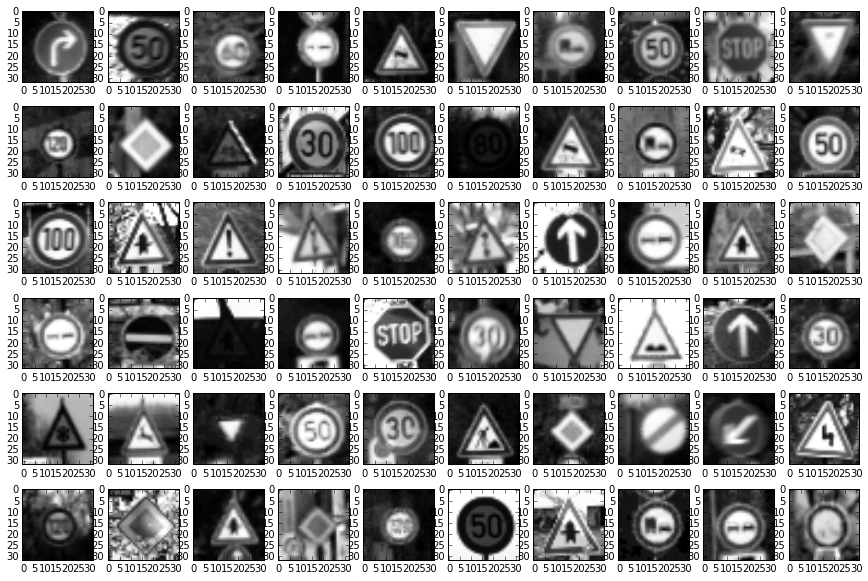

In [64]:
%matplotlib inline
num_of_plotted_imgs = 60
imgs_per_line = 10
random_images = [random.randrange(train_set.shape[0]) for i in xrange(num_of_plotted_imgs)]
print random_images
fig = plt.figure(figsize=(15, 10))
for i in xrange(num_of_plotted_imgs):
    fig.add_subplot(num_of_plotted_imgs / imgs_per_line, imgs_per_line, i+1)
    plt.imshow(train_set[random_images[i]].squeeze(), cmap='Greys_r')
plt.show()

## Add images with random rotations
To further improve the quality of the classifier, add some more images.
These new training images are derived from previous data by rotating and translating randomly.

In [ ]:
# ...

## Pickle the images to a file that can easily be loaded

In [66]:
import pickle
train_name = 'train_data.pkl'
with open(train_name, 'w') as f:
    pickle.dump([train_set, train_labels], f, pickle.HIGHEST_PROTOCOL)

test_name = 'test_data.pkl'
with open(test_name, 'w') as f:
    pickle.dump([test_set, test_labels], f, pickle.HIGHEST_PROTOCOL)
